In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts

import pathlib
import argparse
import scipy
from scipy.stats import kstwo
from scipy.stats import chi2
from scipy import stats

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

Welcome to JupyROOT 6.22/00


In [2]:
dijet_binning = False
poly_cut = True
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
ae_run_n = 113
#qr_run_n, qr_model_str = 4, 'poly'
#qr_run_n, qr_model_str = 5, 'bernstein'
#qr_run_n, qr_model_str, train_share = 8, 'dense_70pct_train', 0.7
#qr_run_n, qr_model_str, train_share = 9, 'dense_50pct_train', 0.5
qr_run_n, qr_model_str, train_share = 7, 'dense_polyfit', 0.2
file_name_root_hist = 'histograms_injSig_PDinj_NA3p5_r'+str(qr_run_n)+'.root'
#quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants = [0.0, 0.3, 0.5, 0.7, 0.9]
#quants = [0.0, 0.7]
quants_inv = [round((1.-q),2) for q in quants] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]

In [3]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_ids = ['qcdSigAllTest'+str(int((1-train_share)*100))+'pct', 'GtoWW35naReco']
sample_id_qcd = sample_ids[0]
sample_id_sig = sample_ids[1]
template_q_idx = 0
quant_tmplt = quants[template_q_idx]

In [4]:
if poly_cut:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
else:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
paths.extend_in_path_data(path_ext_dict)
paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

In [5]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0005265674601680545


In [6]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[template_q_idx+1:] - (quants_tmp)[template_q_idx:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [7]:
if dijet_binning:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
else:
    n_bins = 30
    bin_edges = np.array(np.linspace(1200.,7000., n_bins).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800
    
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [8]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

    for sample_id in sample_ids:
        samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [9]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)

    mjj_min = min(min([np.min(mjj) for mjj in mjj_vals_qcd]), min([np.min(mjj) for mjj in mjj_vals_sig]))
    mjj_max = max(max([np.min(mjj) for mjj in mjj_vals_qcd]), max([np.max(mjj) for mjj in mjj_vals_sig]))
    print('mjj: min {} / max {}'.format(mjj_min, mjj_max))
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[template_q_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     


mjj: min 1200.0001220703125 / max 7469.64697265625


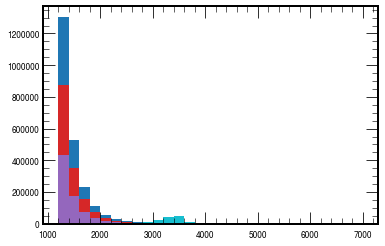

In [10]:
#bin_centers, hist_data = read_root_hist_data(file_name_root_hist)
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quants, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths)

In [11]:
np.set_printoptions(precision=4, suppress=True)

In [12]:
wasserstein_dists = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_ws = []
    pvals_ws = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        d_ws = stats.wasserstein_distance(observed, expected)
        #p_ws = pval_ws(t_ws, n, m)
        
        test_stat_xsecs_ws.append(d_ws)
        #pvals_ws.append(p_ws)
    
    print('WS distance for quantile', quant_test)
    print('t:' , np.array(test_stat_xsecs_ws))
    #print('p-val: ', np.array(pvals_ks))
    print('\n')
    
    wasserstein_dists[quant_test] = test_stat_xsecs_ws

WS distance for quantile 0.3
t: [150.046  149.4284 148.8109 148.1933 147.5759 147.602 ]


WS distance for quantile 0.5
t: [84.6667 84.5129 85.0717 86.6755 88.4025 90.1296]


WS distance for quantile 0.7
t: [169.3908 165.4825 163.8436 166.162  168.8886 172.4527]


WS distance for quantile 0.9
t: [ 90.4713  92.8113  96.4616 100.1119 103.9212 107.7979]




In [13]:
def null_hypothesis_test_stat_dist(expected, eff): # expected already scaled by efficiency or float eff as well?
    
    # check ws distribution distribution from toys
    toy_dists = []
    
    for i in range(int(1e5)):
        # take expected bin heights as mu
        toy = stats.poisson.rvs(expected)
        d_ws_toy = stats.wasserstein_distance(toy, expected)
        toy_dists.append(d_ws_toy)
        
    return toy_dists
    

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


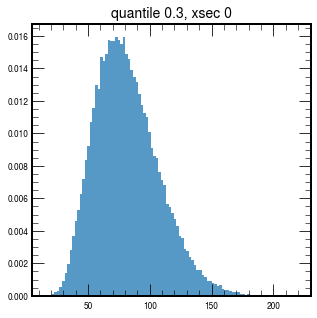

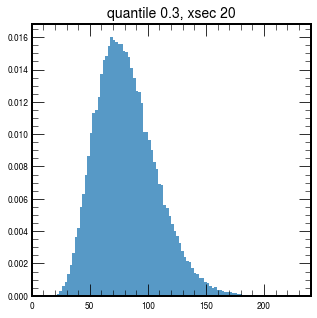

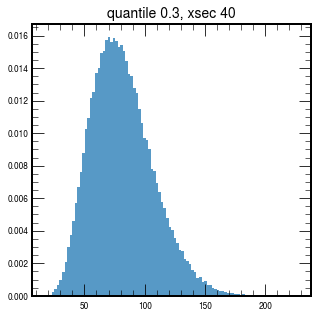

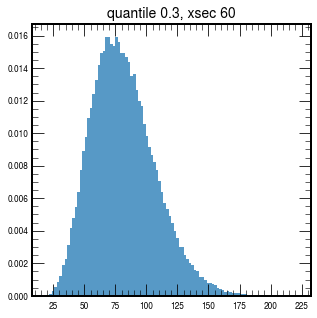

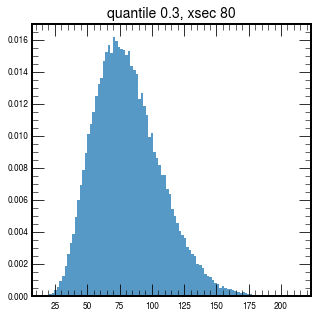

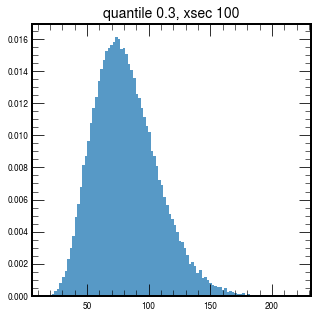

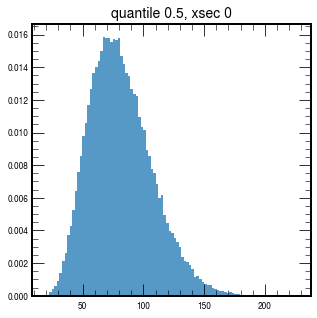

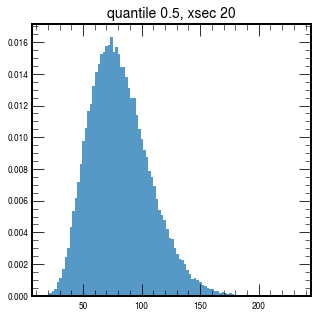

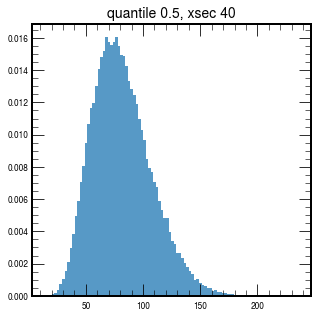

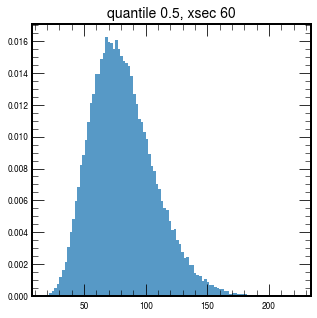

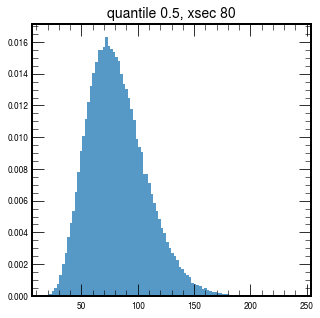

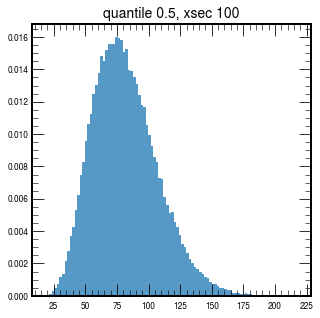

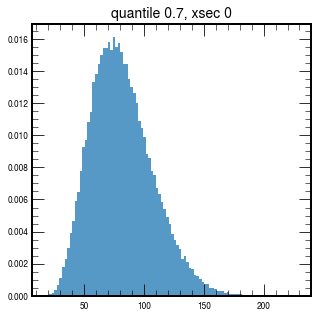

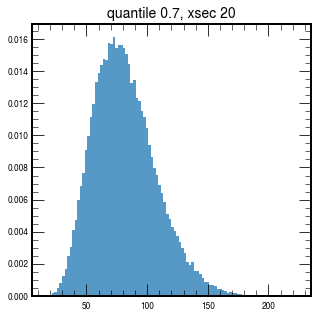

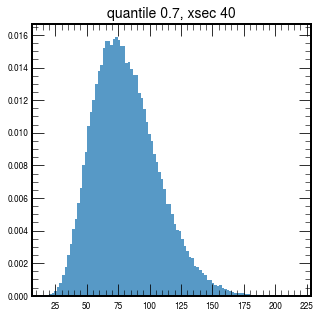

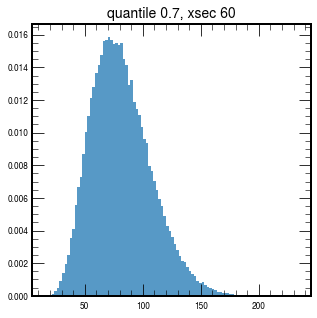

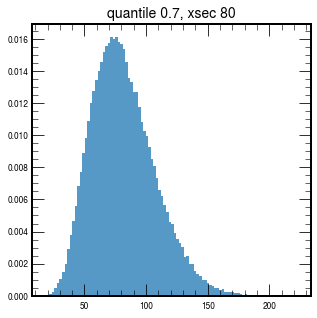

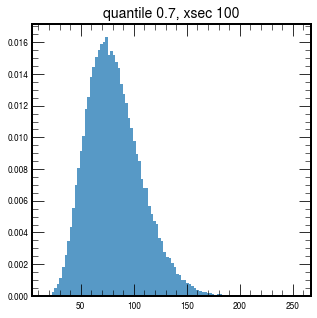

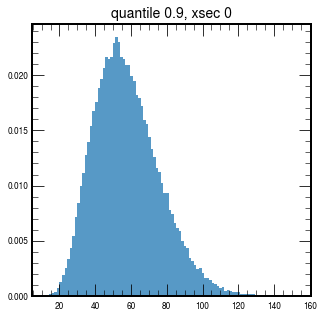

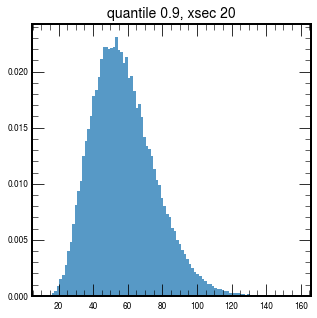

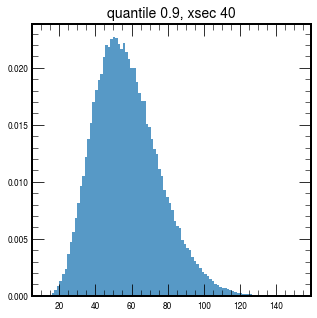

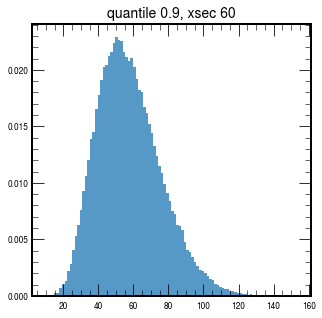

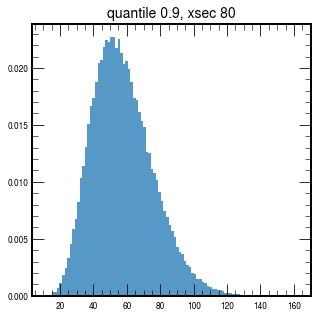

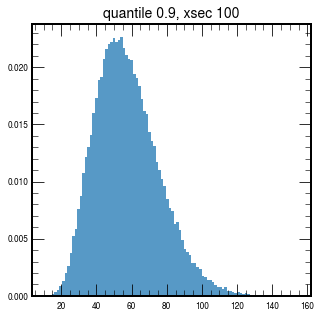

In [15]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        expected = hist_data[quant_tmplt][xsec]*eff
        toy_dists = null_hypothesis_test_stat_dist(expected)
        fig = plt.figure(figsize=(5,5))
        plt.hist(toy_dists, bins=100, density=True, alpha=0.75)
        plt.title('quantile {}, xsec {}'.format(quant_test, xsec), fontsize=14)